<a href="https://colab.research.google.com/github/Gautam0507/MAT496-Introduction-to-LLMs/blob/main/Chapter-5/Chapeter5_Pretraining_on_unlabeled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1 Evaluating generative text models

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import tiktoken

## 5.1.1 Using GPT to generate text

### Code borrowed from chapter 4

All code here is taken from chapter 4. Should be put into a python file and imported instead.

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = 1)
  return idx

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased= False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    norm_x = self.scale * norm_x + self.shift
    return norm_x

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    GELU = 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi, dtype = torch.float32)) * (x + 0.044715 * torch.pow(x, 3))))
    return GELU

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1,2)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

### Initializing the model for chapter 5

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    #Shortened the context length from 1024 to 256 tokens (reducing computation)
    "context_length" : 256,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Defining Utility functions for text to token ID Conversion

- `torch.tensor.unsqueeze()` - adds the batch dimension

In [ ]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

- `torch.tensor.squeeze()` - removes the batch dimension

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model = model,
                                 idx = text_to_token_ids(start_context, tokenizer),
                                 max_new_tokens=10,
                                 context_size = GPT_CONFIG_124M["context_length"])

print(f"Output text: \n {token_ids_to_text(token_ids, tokenizer)}")

Output text: 
 Every effort moves you!!!!!!!!!!


## 5.1.2 Calculating the text generation loss

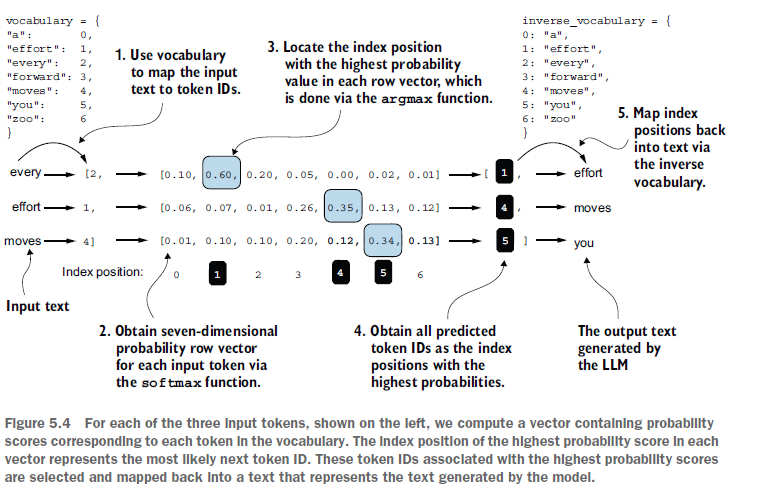

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40, 1107, 588]])      # "I really like"]

targets = torch.tensor([[3626, 6100, 345],    # [" effort moves you",
                        [1107, 588, 11311]])  # " really like chocolate"]

Shape Explanation
- $2$ - batch size (number of inputs)  
- $3$ - Number of tokens in each input
- $50257$ - Embedding dimensioality

In [ ]:
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim = -1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [ ]:
token_ids = torch.argmax(probas, dim = -1, keepdim = True)
print(f"Token IDs: \n{token_ids}")

Token IDs: 
tensor([[[0],
         [0],
         [0]],

        [[0],
         [0],
         [0]]])


In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1"
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1!!!


In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f"Text 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f"Text 2: {target_probas_2}")

Text 1: tensor([nan, nan, nan])
Text 2: tensor([nan, nan, nan])


Working with logarithms of probability scores is more manageable in mathematical
optimization than handling the scores directly.

TODO: Look into appendix B for reasoning

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([nan, nan, nan, nan, nan, nan])


In [ ]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(nan)


the goal is to bring the
negative average log probability down to 0

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(nan)


The above loss is called the cross entropy loss
`torch.nn.functional.cross_entropy(torch.tensor1, torch.tensor2)`

In [ ]:
print(f"Logits shpae: {logits.shape}")
print(f"Targets shpae: {targets.shape}")

Logits shpae: torch.Size([2, 3, 50257])
Targets shpae: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print(f"Flattened logits: {logits_flat.shape}")
print(f"Flattened targets: {targets_flat.shape}")

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(nan)


TODO: Look into perplexity on pg 140

## 5.1.3 Calculating the training and validation set losses